In [1]:
import geopandas as gpd
import contextily as cx

from data.geo import label_point_dispersion
from data.constants import (WEB_CRS)

In [2]:
train_file_in = "../data/raw/train_stations.geojson"
bus_routes_file_in = "../data/raw/bus_routes.geojson"
bus_stops_file_in = "../data/raw/bus_stops.geojson"

In [3]:
train_stations = gpd.read_file(train_file_in)
bus_routes = gpd.read_file(bus_routes_file_in)
bus_stops = gpd.read_file(bus_stops_file_in)


In [4]:
bus_stops_pk = ['STREET','CROSS_ST','CITY']

# Cardinality

In [5]:
print("We expect {} stations, {} bus routes, {} bus stops".format(
    train_stations.map_id.nunique(),
    bus_routes.route.nunique(),
    bus_stops.drop_duplicates(subset=bus_stops_pk).shape[0],
))

We expect 144 stations, 127 bus routes, 6517 bus stops


# Relational

## Primary Key of Bus Stops

In [6]:
bus_stops['ngeom'] = bus_stops.groupby(bus_stops_pk).geometry.transform('nunique')
bus_stops['ngeom'].describe()
# There are often more than one point per bus stop. Are they truly different points?

count    14069.000000
mean         1.806525
std          0.629084
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         11.000000
Name: ngeom, dtype: float64

In [7]:
bus_stops = bus_stops.pipe(label_point_dispersion, bus_stops_pk)

In [8]:
assert all(bus_stops['diam_mi'] < .5), "Primary key approx accurate to .5mi"

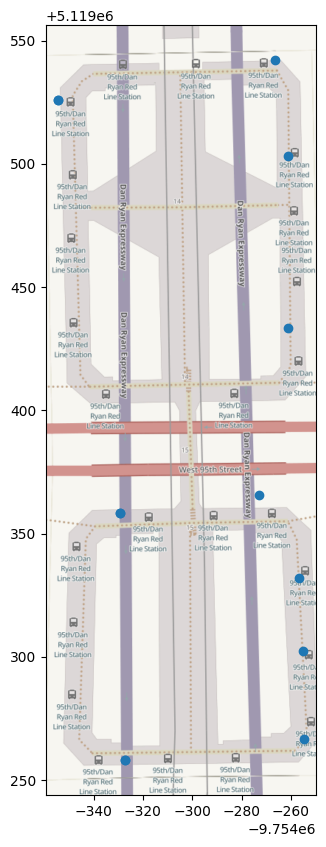

In [9]:
# Some stops are at a transit center with MANY stop points
# that are still relatively near eachother (on the same block).
bus_stops_webmerc = bus_stops[bus_stops['PUBLIC_NAME']=="95th Red Line Station"].to_crs(WEB_CRS)
ax = bus_stops_webmerc.plot(figsize=(10, 10))
cx.add_basemap(ax, attribution=False)

/Users/eric/Dev/DNCTransit/.venv/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


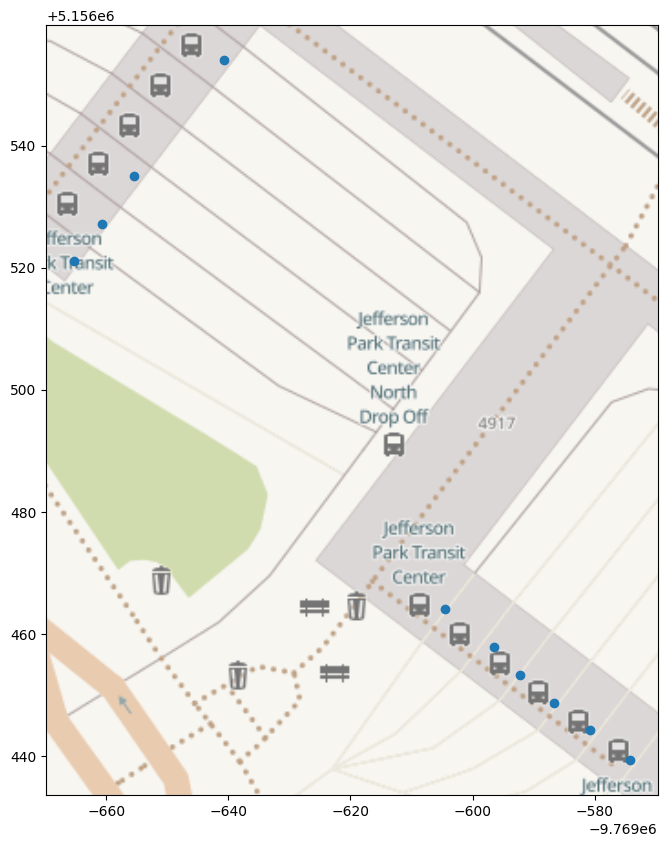

In [10]:
# Some stops are at a transit center with MANY stop points
# that are still relatively near eachother (on the same block).
bus_stops_webmerc = bus_stops[bus_stops['PUBLIC_NAME']=="Jefferson Park Transit Center"].to_crs(WEB_CRS)
ax = bus_stops_webmerc.plot(figsize=(10, 10))
cx.add_basemap(ax, attribution=False)

## Primary Key of Train Stations

In [11]:
assert all(train_stations.groupby('stop_id').geometry.nunique() == 1), "stop_id is PK"

In [12]:
train_stations = train_stations.pipe(label_point_dispersion, 'map_id')
assert all(train_stations['diam_mi'] < .25), "Primary key approx accurate to .25mi"

# TL/DR

- map_id is the PK of train stations
- route is the PK of bus routes
- STREET, CROSS_ST, CITY is the composite PK of bus stations
